Eigenvalues at BoC:
[-3.95507727e+03 -1.01579363e+01 -2.44930265e+00 -9.92252442e-01
 -5.76289236e-01 -1.97753994e-01 -7.91498420e-02 -2.09473169e-02
 -1.19155928e-02]

Eigenvalues at EoC:
[-3.91852852e+03 -1.00971537e+01 -2.39794386e+00 -1.31082085e+00
 -5.86340267e-01 -2.15889353e-01 -8.27831159e-02 -2.40100095e-02
 -1.22268028e-02]


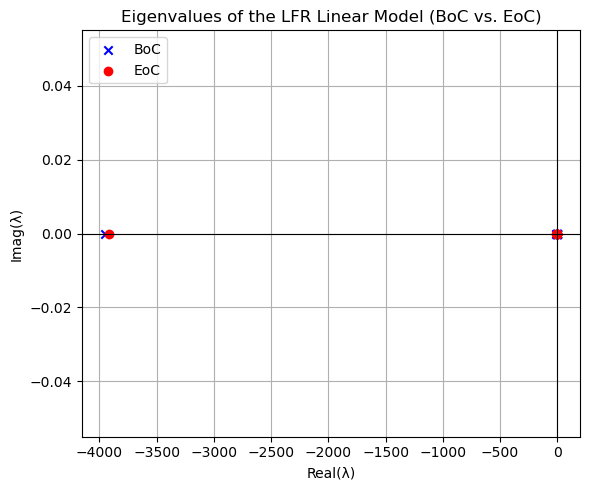

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def build_A_matrix(alpha_f, alpha_c,
                   beta, beta_i, lam, Lambda,
                   tau_f=1.0, tau_c=1.0, tau_0=1.0,
                   P0_K_tau_f=0.0):
    """
    Builds and returns the A matrix for the 6-group + thermal-hydraulics 
    linear model, given the sum of reactivity coefficients alpha_f, alpha_c,
    the delayed neutron data (beta, beta_i, lam[]), the prompt gen time Lambda,
    and example thermal-hydraulic time constants.

    Parameters
    ----------
    alpha_f : float
        Combined Doppler + axial expansion reactivity coefficient (dimensionless)
    alpha_c : float
        Combined coolant density + radial expansion reactivity coefficient (dimless)
    beta : float
        Total delayed neutron fraction (dimensionless)
    beta_i : list or array of floats
        Individual delayed neutron fractions for 6 groups (dimensionless)
    lam : list or array of floats
        Decay constants for 6 groups (1/s)
    Lambda : float
        Prompt neutron generation time (s)
    tau_f : float, optional
        Fuel time constant (s)
    tau_c : float, optional
        Coolant time constant (s)
    tau_0 : float, optional
        Additional coolant/loop time constant (s)
    P0_K_tau_f : float, optional
        Term for (P0 / (K * tau_f)) in the linearized fuel temperature equation

    Returns
    -------
    A : 2D numpy array of shape (9, 9)
        State matrix A
    """

    # Number of precursor groups
    n_dg = 6

    # Unpack the first 7 states for neutron + precursors
    # x = [ psi, eta1, eta2, eta3, eta4, eta5, eta6, Tf, Tc ]
    # We'll build row by row:

    A = np.zeros((9, 9))

    # 1) dpsi/dt row
    #   dpsi = [-(beta/Lambda)*psi + sum_{i=1..6}(beta_i/Lambda * eta_i)
    #           + (alpha_f/Lambda)*Tf + (alpha_c/Lambda)*Tc ]
    A[0, 0] = -(beta)/Lambda
    for i in range(n_dg):
        A[0, 1 + i] = beta_i[i]/Lambda
    A[0, 7] = alpha_f / Lambda  # Tf
    A[0, 8] = alpha_c / Lambda  # Tc

    # 2) Precursor rows: detai/dt = lam_i*psi - lam_i*eta_i
    for i in range(n_dg):
        A[1 + i, 0] = lam[i]       # + lam_i * psi
        A[1 + i, 1 + i] = -lam[i]  # - lam_i * eta_i

    # 3) Fuel temperature row (8th state => index 7)
    #   dTf = P0_K_tau_f
    #         - (1/tau_f)*Tf
    #         + (1/tau_f)*Tc
    A[7, 0] = P0_K_tau_f  
    A[7, 7] = -1.0 / tau_f
    A[7, 8] =  1.0 / tau_f

    # 4) Coolant temperature row (9th state => index 8)
    #   dTc = (1/tau_c)*Tf
    #         - [2/tau_0 + 1/tau_c]*Tc
    A[8, 7] = 1.0 / tau_c
    A[8, 8] = - (2.0 / tau_0 + 1.0 / tau_c)

    return A

def max_real_eig(A):
    """
    Returns the maximum real part of the eigenvalues of matrix A.
    """
    eigvals, _ = np.linalg.eig(A)
    
    return np.max(eigvals.real)

def main():
    # ----------------------------------------------------------------------
    # 1. Define parameters for BoC (Beginning of Cycle)
    #    All reactivity feedback coefficients in [pcm/°C], 
    #    then convert to dimensionless reactivity: 1 pcm = 1e-5 (dk/k)
    # ----------------------------------------------------------------------
    alpha_D_boc = -0.15    # pcm/°C
    alpha_C_boc = -1.2267  # pcm/°C
    alpha_A_boc = -0.0429  # pcm/°C
    alpha_R_boc = -0.7741  # pcm/°C
    
    # Combine Doppler + Axial for fuel; Coolant + Radial for coolant
    alpha_f_boc = (alpha_D_boc + alpha_A_boc) * 1e-5  # convert pcm->dimensionless
    alpha_c_boc = (alpha_C_boc + alpha_R_boc) * 1e-5

    # Delayed neutron data at BoC
    # Beta total, in pcm
    beta_boc_pcm = 319.0
    beta_boc = beta_boc_pcm * 1e-5  # dimensionless

    # Individual group fractions in pcm
    beta1_boc = 6.142
    beta2_boc = 71.40
    beta3_boc = 34.86
    beta4_boc = 114.1
    beta5_boc = 69.92
    beta6_boc = 22.68
    beta_i_boc = np.array([beta1_boc, beta2_boc, beta3_boc,
                           beta4_boc, beta5_boc, beta6_boc]) * 1e-5  # dimensionless

    # Decay constants at BoC (s^-1) 
    lam_boc = np.array([0.0125, 0.0292, 0.0895, 0.2575, 0.6037, 2.6688])
    
    # Prompt neutron generation time (microseconds => seconds)
    Lambda_boc_us = 0.8066
    Lambda_boc = Lambda_boc_us * 1.0e-6  # s

    tau_f = 1.336  # s
    tau_c = 1.321   # s
    tau_0 = 0.210   # s

    P0_K_tau_f = 374.25

    # Build A for BoC
    A_boc = build_A_matrix(alpha_f_boc, alpha_c_boc,
                           beta_boc, beta_i_boc, lam_boc, Lambda_boc,
                           tau_f, tau_c, tau_0, P0_K_tau_f)

    # ----------------------------------------------------------------------
    # 2. Define parameters for EoC (End of Cycle)
    # ----------------------------------------------------------------------
    alpha_D_eoc = -0.17
    alpha_C_eoc = -1.995
    alpha_A_eoc = -0.2374
    alpha_R_eoc = -0.7144

    alpha_f_eoc = (alpha_D_eoc + alpha_A_eoc) * 1e-5
    alpha_c_eoc = (alpha_C_eoc + alpha_R_eoc) * 1e-5

    beta_eoc_pcm = 333.0
    beta_eoc = beta_eoc_pcm * 1e-5

    # Group fractions EoC 
    beta1_eoc = 6.224
    beta2_eoc = 72.33
    beta3_eoc = 35.34
    beta4_eoc = 115.5
    beta5_eoc = 70.75
    beta6_eoc = 22.89
    beta_i_eoc = np.array([beta1_eoc, beta2_eoc, beta3_eoc,
                           beta4_eoc, beta5_eoc, beta6_eoc]) * 1e-5

    # Decay constants EoC 
    lam_eoc = np.array([0.0125, 0.0292, 0.0895, 0.2575, 0.6025, 2.6661])

    Lambda_eoc_us = 0.8498
    Lambda_eoc = Lambda_eoc_us * 1.0e-6  # s

    # Build A for EoC
    A_eoc = build_A_matrix(alpha_f_eoc, alpha_c_eoc,
                           beta_eoc, beta_i_eoc, lam_eoc, Lambda_eoc,
                           tau_f, tau_c, tau_0, P0_K_tau_f)

    # ----------------------------------------------------------------------
    # 3. Compute eigenvalues
    # ----------------------------------------------------------------------
    eigvals_boc, eigvecs_boc = np.linalg.eig(A_boc)
    eigvals_eoc, eigvecs_eoc = np.linalg.eig(A_eoc)

    # ----------------------------------------------------------------------
    # 4. Print and Plot
    # ----------------------------------------------------------------------
    print("Eigenvalues at BoC:")
    print(eigvals_boc)
    print("\nEigenvalues at EoC:")
    print(eigvals_eoc)

    # Plot real vs imaginary parts
    plt.figure(figsize=(6,5))
    plt.scatter(eigvals_boc.real, eigvals_boc.imag,
                marker='x', color='b', label='BoC')
    plt.scatter(eigvals_eoc.real, eigvals_eoc.imag,
                marker='o', color='r', label='EoC')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.xlabel('Real(λ)')
    plt.ylabel('Imag(λ)')
    plt.title('Eigenvalues of the LFR Linear Model (BoC vs. EoC)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()
